In [35]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64, img_as_ubyte
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

In [36]:
_depth_stride = {64 : 32, 32 : 16, 16 : 8, 8 : 4, 4 : 4}
_family_container = {}
_threshold_bits = 10
_scale_bits = 5
_bias_bits = 7

metadata = []
codebook = []
codebook_bak = []
_quad_split = []
_quad_split_bak = []

In [37]:
def _int_quantize(number, bits):
    return np.int(np.rint((2 ** bits - 1) * number))

def _float_quantize(number, bits):
    return _int_quantize(number, bits) / (2 ** bits - 1)

In [38]:
def _affine(image, rotate_flip):
    times, flip = rotate_flip % 4, rotate_flip // 4
    if flip == 1:
        image = np.flip(image, 1)
    return np.rot90(image, times)

In [39]:
def _get_id(block, block_size):
    block_size = block_size // 2
    sum1 = np.sum(block[: block_size, : block_size])
    sum2 = np.sum(block[: block_size, block_size : 2 * block_size])
    sum3 = np.sum(block[block_size : 2 * block_size, block_size : 2 * block_size])
    sum4 = np.sum(block[block_size : 2 * block_size, : block_size])
    l = [(sum1, 0), (sum2, 1), (sum3, 2), (sum4, 3)]
    block_id = "".join(str(x[1]) for x in sorted(l))
    if (len(block_id) != 4):
        assert False, "block_id len = {}, d : {}".format(len(block_id), l)
    return block_id

def _determine_family(resized_image, block_size):
    stride = _depth_stride[block_size]
    H, W = resized_image.shape
    xs = np.arange(0, H, stride)
    ys = np.arange(0, W, stride)
#     print(f"stride={stride},block_size={block_size},xs={xs}, ys={ys}")
    for x, y in itertools.product(xs, ys):
        for tf in range(8):
            domain_id = _get_id(_affine(resized_image[x : x + block_size, y : y + block_size], tf), block_size)
            # print(f"domain_id={domain_id}")
            _family_container.update({(x, y, block_size, tf) : domain_id})

In [40]:
def _quadtree_find_rank_transform(image, resized_image, x, y, block_size):
    stride = _depth_stride[block_size]
    
    rank_block = image[x : x + block_size, y : y + block_size] 
    rank_block_id = _get_id(rank_block, block_size)
    difference = np.inf
    best_transform = None

    H, W = resized_image.shape
    dims = block_size ** 2
#     print(f"x={x},y={y},stride={stride},H={H},W={W},block_size={block_size}")

    xs = np.arange(0, H, stride)
    ys = np.arange(0, W, stride)
    for x_domain in xs:
        for y_domain in ys:
            if x_domain + block_size > H or y_domain + block_size > W:
                continue

            match_any = False
            for tf in range(8):
                match_any |= rank_block_id == _family_container[(x_domain, y_domain, block_size, tf)] or \
                        rank_block_id == _family_container[(x_domain, y_domain, block_size, tf)][::-1]
            if not match_any:
                continue

            domain_block = resized_image[x_domain : x_domain + block_size, y_domain : y_domain + block_size]
            rank_sum = np.sum(rank_block)
            rank_squared = np.sum(rank_block * rank_block)

            domain_sum = np.sum(domain_block)
            domain_squared = np.sum(domain_block * domain_block)
            for flip in range(2):
                for times in range(4):
                    if rank_block_id != _family_container[(x_domain, y_domain, block_size, 4 * flip + times)] and \
                        rank_block_id != _family_container[(x_domain, y_domain, block_size, 4 * flip + times)][::-1]:
                        continue
                    domain_block = _affine(domain_block, 4 * flip + times)
                    element_wise = np.sum(domain_block * rank_block)

                    denominator = dims * domain_squared - domain_sum ** 2
                    if np.abs(denominator) > 1e-8: 
                        scale = (dims * element_wise - domain_sum * rank_sum) / denominator
                        scale = np.sign(scale) * min(1, np.abs(scale))
                        scale = _float_quantize(scale, _scale_bits)
                    else:
                        scale = 0
                    bias = (rank_sum - scale * domain_sum) / dims
                    bias = np.sign(bias) * min(1, np.abs(bias))
                    bias = _float_quantize(bias, _bias_bits)

                    curr_diff = np.sum((rank_block - (domain_block * scale + bias)) ** 2)
                    if curr_diff < difference:
                        difference = curr_diff
                        scale_is_negative = np.int(scale < 0)
                        bias_is_negative = np.int(bias < 0)

                        scale = _int_quantize(scale, _scale_bits)
                        bias = _int_quantize(bias, _bias_bits)

                        best_transform = (x_domain, y_domain, times + flip * 4, 
                                          (np.abs(scale), scale_is_negative, np.abs(bias), bias_is_negative))
    if best_transform is None:
        print("Transform wasn't found, block_size : {}".format(block_size))
        print(Counter(self._family_container.values()))
        print(len(Counter(self._family_container.values())))
        assert False
    return best_transform, difference

In [41]:
def _quadtree_find_tf(image, resized_image, x, y, block_size, threshold):
    transform, loss = _quadtree_find_rank_transform(image, resized_image, x, y, block_size)
    loss /= block_size ** 2
    loss = np.sqrt(loss)
    # print(f"x={x},y={y},transform={transform},loss={loss},block_size={block_size},threshold={threshold}, minblock={min_block_size_reached}")
    if loss > threshold and block_size > 4:
        block_size = block_size // 2
        # is recursive
        _quad_split.append(1)
        _quadtree_find_tf(image, resized_image, x, y, block_size, threshold)
        _quadtree_find_tf(image, resized_image, x, y + block_size, block_size, threshold)
        _quadtree_find_tf(image, resized_image, x + block_size, y  + block_size, block_size, threshold)
        _quadtree_find_tf(image, resized_image, x + block_size, y, block_size, threshold)
        return
    # no recursive
    _quad_split.append(0)
    codebook.append(transform)

In [42]:
def _quadtree_compress(image, block_size=32, threshold=63):
    H, W = image.shape
    xs = range(0, H, block_size)
    ys = range(0, W, block_size)
    
    source_image = img_as_float64(image)
    metadata.append([H, W, 0, block_size, threshold])
    
    threshold /= 2 ** _threshold_bits
    
    resized_image = resize(source_image, (H // 2, W // 2))
    for t_block_size in [32, 16, 8, 4]:
        _determine_family(resized_image, t_block_size)
    for x, y in tqdm(itertools.product(xs, ys), total = len(xs) * len(ys)):
        _quadtree_find_tf(source_image, resized_image, x, y, block_size, threshold)


In [43]:
def _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y):
    rank_block = image[x : x + block_size, y : y + block_size]
    
    if len(_quad_split) > 0:
        recursive_dig = _quad_split[0]
        _quad_split.pop(0)
    else:
        raise Exception("_quad_split is empty...")
    if recursive_dig and block_size  > 4:
        block_size = block_size // 2
        rank_block[: block_size, : block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y)

        rank_block[: block_size, block_size : 2 * block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y + block_size)

        rank_block[block_size : 2 * block_size, block_size : 2 * block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x + block_size, y + block_size)

        rank_block[block_size : 2 * block_size, : block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x + block_size, y)
        return rank_block
    
    if len(codebook) > 0:
        transform = codebook[0]
        codebook.pop(0)
    else:
        raise Exception("codebook is empty...")
    domain_x, domain_y, rotate_flip, (scale, scale_is_neg, bias, bias_is_neg) = transform
    scale /= 2 ** _scale_bits - 1
    bias  /= 2 ** _bias_bits  - 1
    if bias_is_neg:
        bias *= -1
    if scale_is_neg:
        scale *= -1
    rank_block = scale * _affine(resized_image[domain_x : domain_x + block_size, domain_y : domain_y + block_size], rotate_flip) + bias
    return rank_block

def _quadtree_apply_transforms(image, resized_image, codebook, _quad_split, block_size=32):
    N, M = image.shape
    xs = range(0, N, block_size)
    ys = range(0, M, block_size)
    for x, y in itertools.product(xs, ys):
        image[x : x + block_size, y : y + block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y)
    return image

In [44]:
def _quadtree_decompress(byte_array, num_iters=10):
    [[height, width, colored, block_size, threshold]] = metadata
    
    codebook = copy.deepcopy(codebook_bak)
    _quad_split = copy.deepcopy(_quad_split_bak)
    image = img_as_float64(np.ones((height, width)))
    for iteration in range(num_iters):
        resized_image = resize(image, (height // 2, width // 2))
        image = _quadtree_apply_transforms(image, resized_image, codebook, _quad_split, block_size=block_size)
        codebook = copy.deepcopy(codebook_bak)
        _quad_split = copy.deepcopy(_quad_split_bak)

    image = np.clip(image, -1, 1)
    return img_as_ubyte(image)

In [46]:
import copy
# reset everything
metadata.clear()
codebook.clear()
codebook_bak.clear()
_quad_split.clear()
_quad_split_bak.clear()

lenna_rgb_512x512 = io.imread('data/lena.jpg')
# lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_512x512) * 255).astype('uint8')
result_16x4 = _quadtree_compress(image=lenna_gray_256x256, block_size=32, threshold=300)

# get both baks
codebook_bak = copy.deepcopy(codebook)
_quad_split_bak = copy.deepcopy(_quad_split)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:04<00:00, 53.27it/s]


In [47]:
metadata

[[512, 512, 0, 32, 300]]

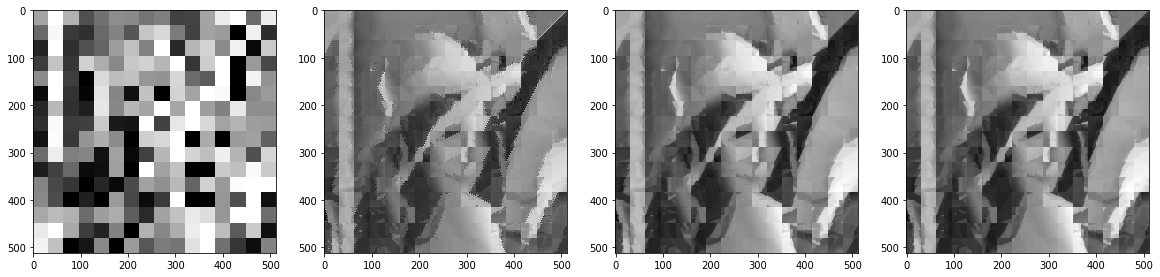

In [48]:
n_iters = [1, 5, 10, 20]
imgs = []
imgs = [_quadtree_decompress(result_16x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(20, 8))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')
plt.show()